Machine learning model using time series dataset<br>
Ellion Blessan<br>
ellionblessan@gmail.com

Dataset: [Intel Stock Prices Historical Data (INTC) | Kaggle](https://www.kaggle.com/datasets/tosinabase/intel-stock-prices-historical-data-intc)

# Importing dependencies

In [1]:
import zipfile
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rleonb","key":"7a755e4b1cd0edc5eeb3429063bda95d"}'}

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tosinabase/intel-stock-prices-historical-data-intc

100% 235k/235k [00:00<00:00, 782kB/s]
100% 235k/235k [00:00<00:00, 781kB/s]


In [6]:
local_zip = 'intel-stock-prices-historical-data-intc.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.199557,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.197961,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.202750,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.201952,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.194767,12172800
...,...,...,...,...,...,...,...
10356,2021-04-13,65.610001,65.629997,64.209999,65.220001,65.220001,26822000
10357,2021-04-14,65.309998,65.379997,63.840000,64.190002,64.190002,25768400
10358,2021-04-15,63.970001,65.220001,63.680000,65.019997,65.019997,24927700
10359,2021-04-16,65.330002,65.519997,64.570000,64.750000,64.750000,24607000


# Pre-processing dataset

In [8]:
new_df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
new_df.set_index('Date', inplace= True)
new_df

,Close
Date,
1980-03-17,0.325521
1980-03-18,0.322917
1980-03-19,0.330729
1980-03-20,0.329427
1980-03-21,0.317708
...,...
2021-04-13,65.220001
2021-04-14,64.190002
2021-04-15,65.019997


In [9]:
new_df.isnull().sum()

Close    0
dtype: int64

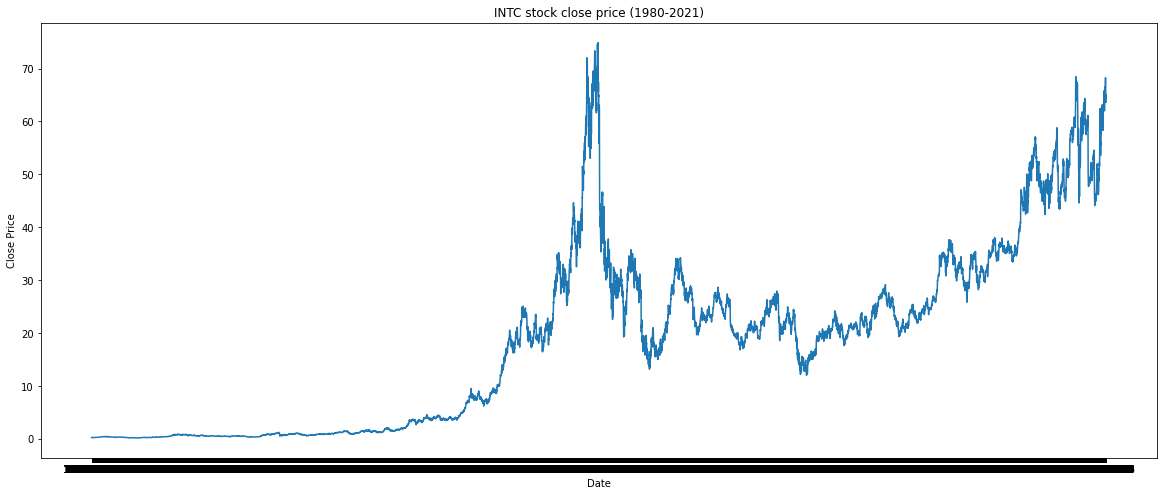

In [10]:
plt.figure(figsize=(20,8))
plt.plot(new_df)
plt.title('INTC stock close price (1980-2021)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(new_df.values)
scaled_df

array([[0.001465  ],
       [0.00143012],
       [0.00153475],
       ...,
       [0.86799954],
       [0.86438313],
       [0.84938158]])

In [12]:
date = df['Date'].values
close = df['Close'].values

# Model and plot

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [14]:
threshold = (scaled_df.max() - scaled_df.min()) * 10/100
threshold

0.1

In [15]:
x_train, x_test, y_train, y_test = train_test_split(scaled_df, date, test_size=0.2, 
                                                    random_state=21112022 , shuffle=False)

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold):
      self.model.stop_training = True
      print("\nMean Absolute Error of the model has reached less than 10% of data scale")
callbacks = myCallback()

In [17]:
train_close = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
test_close = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate=2.0000e-04, momentum=0.9)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(4, input_shape=(1, 1)),
  tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [23]:
history = model.fit(train_close, epochs=100, validation_data=test_close, callbacks=[callbacks])

Epoch 1/100
83/83 [==============================] - 5s 32ms/step - loss: 0.0244 - mae: 0.1591 - val_loss: 0.0857 - val_mae: 0.3828
Epoch 2/100
83/83 [==============================] - 2s 18ms/step - loss: 0.0187 - mae: 0.1536 - val_loss: 0.0721 - val_mae: 0.3452
Epoch 3/100
83/83 [==============================] - 2s 14ms/step - loss: 0.0173 - mae: 0.1541 - val_loss: 0.0661 - val_mae: 0.3279
Epoch 4/100
83/83 [==============================] - 2s 14ms/step - loss: 0.0170 - mae: 0.1547 - val_loss: 0.0632 - val_mae: 0.3190
Epoch 5/100
83/83 [==============================] - 2s 18ms/step - loss: 0.0169 - mae: 0.1551 - val_loss: 0.0618 - val_mae: 0.3147
Epoch 6/100
83/83 [==============================] - 2s 14ms/step - loss: 0.0169 - mae: 0.1553 - val_loss: 0.0613 - val_mae: 0.3134
Epoch 7/100
83/83 [==============================] - 2s 14ms/step - loss: 0.0169 - mae: 0.1554 - val_loss: 0.0610 - val_mae: 0.3125
Epoch 8/100
83/83 [==============================] - 2s 14ms/step - loss: 0.

KeyboardInterrupt: ignored

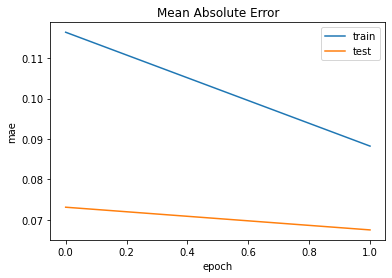

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

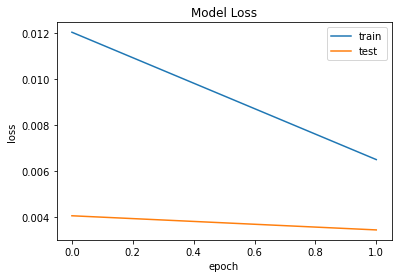

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()